# **temp-sol-dyn.py**
> ### Température Sol Dynamique (temp-sol-dyn.py) - Calcule les solutions de l'équation de la chaleur 1D discrétisée à partir d'un fichier météo 
### Nicolas Désilles (nicolas@ndlabs.fr) - 2022/2023 - PIRD 5GCU INSA Lyon

In [3]:
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

Importation du fichier météo et traitement

In [4]:
wthData = pd.read_csv(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)),"02_Data/WTH_DATA_1973_LYON.csv"),sep="\t")

tempAir = 273.15 + wthData['Température Air'].values

print("max " + str(max(tempAir)))
print("min " + str(min(tempAir)))
print("moy " + str(sum(tempAir)/len(tempAir)))

time = wthData['CurrentTime'].values
time = pd.to_datetime(time)
time = np.array(time,dtype=np.datetime64)

numberOfTimeSteps = len(tempAir)

max 306.15
min 263.15
moy 283.9896118720998


/var/folders/4f/kpzdgckj6zlcvwjk8b8_3f2w0000gn/T/ipykernel_79987/2738033663.py:11: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  time = np.array(time,dtype=np.datetime64)


Définition des constantes

In [5]:
# Thermal conductivity
k = 2.9 #[W/(m.K)]

# Density
rho = 2.75*(10**3) #[kg/m3]

# Specific Heat Capacity
cp = 0.89 #[kJ/(kg.K)]

# Thermal Diffusivity
alpha = (k/(rho*cp*(10**(-3))))*10**(-6)

#Time step [s]
dt = 3600

#Number of spatial points
n = 400

#Arbitrary thickness of semi-infinite solid
L = 35 #[m]

#Spatial step [m]
dy = L/n

#Mean deep soil temperature [K]
TsolInf = 273.15 + 14

Définition du vecteur de température

In [6]:
soilTemperatures = np.zeros((n,numberOfTimeSteps))

Conditions initiales

In [7]:
soilTemperatures[:,0] = TsolInf

Conditions limites

In [8]:
for j in range(numberOfTimeSteps):

    soilTemperatures[0,j] = tempAir[j]
    soilTemperatures[n-1,j] = TsolInf

Calcul de la matrice de températures (EDC 1D)

In [9]:
for j in tqdm(range(numberOfTimeSteps-1), desc="Processing...",ncols=100,total=numberOfTimeSteps-1,leave=True):

    for i in range(1,n-1):

        soilTemperatures[i,j+1] = soilTemperatures[i,j] + ((alpha*dt)/dy)*(soilTemperatures[i+1,j] - 2*soilTemperatures[i,j] + soilTemperatures[i-1,j])

soilTemperatures = soilTemperatures - 273.15

Processing...: 100%|██████████████████████████████████████████| 8759/8759 [00:02<00:00, 4131.80it/s]


Figure

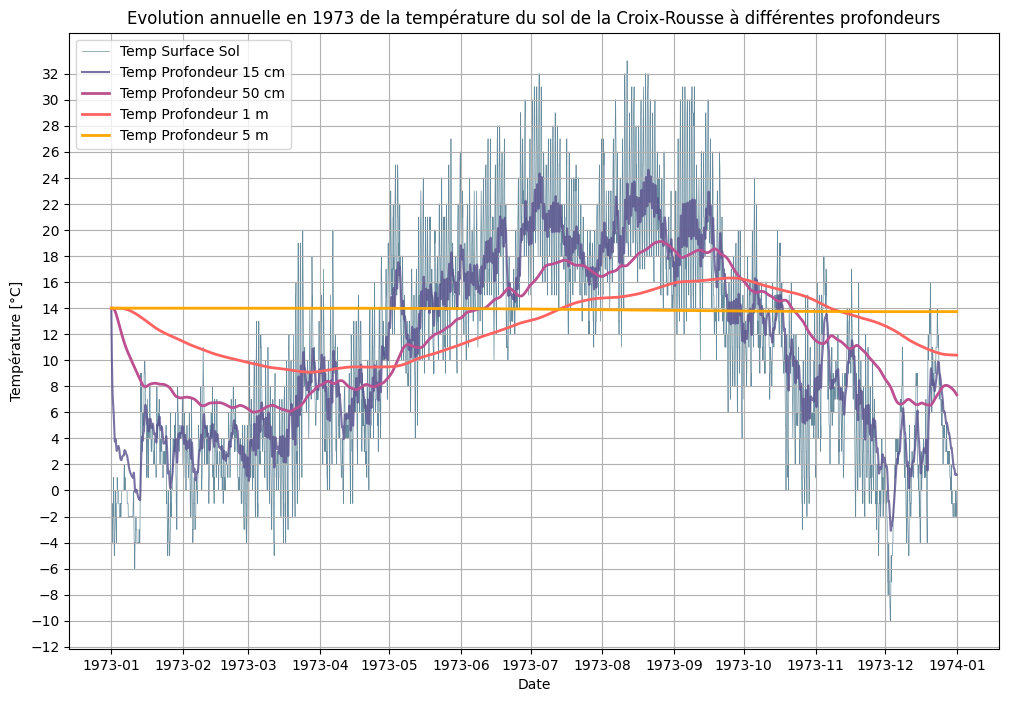

In [10]:
tempSurface = soilTemperatures[0,:]

prof1 = 0.15 #[m]
prof2 = 0.5 #[m]
prof3 = 1 #[m]
prof4 = 5 #[m]

indexProf1 = int(math.floor(prof1/dy))
indexProf2 = int(math.floor(prof2/dy))
indexProf3 = int(math.floor(prof3/dy))
indexProf4 = int(math.floor(prof4/dy))

tempProf1 = soilTemperatures[indexProf1,:]
tempProf2 = soilTemperatures[indexProf2,:]
tempProf3 = soilTemperatures[indexProf3,:]
tempProf4 = soilTemperatures[indexProf4,:]

fig, ax = plt.subplots(figsize=(12,8))

colors = ['#003f5c','#58508d','#bc5090','#ff6361','#ffa600']

ax.plot(time,tempSurface,label='Temp Surface Sol',alpha=0.6,linewidth=0.5,zorder=1,color=colors[0])
ax.plot(time,tempProf1,label='Temp Profondeur 15 cm', alpha=0.8,zorder=2,color=colors[1])
ax.plot(time,tempProf2,label='Temp Profondeur 50 cm',linewidth=2,zorder=3,color=colors[2])
ax.plot(time,tempProf3,label='Temp Profondeur 1 m',linewidth=2,zorder=4,color=colors[3])
ax.plot(time,tempProf4,label='Temp Profondeur 5 m',linewidth=2,zorder=5,color=colors[4])

ax.grid(which='both')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.set_yticks([2*p for p in range(-6,17)])
ax.set_xlabel('Date')
ax.set_ylabel('Température [°C]')
ax.legend(loc='upper left')
ax.set_title('Evolution annuelle en 1973 de la température du sol de la Croix-Rousse à différentes profondeurs')

plt.show()